In [94]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..")
from src.query_funcs import *
import warnings
warnings.filterwarnings('ignore')

Vamos a extraer la información de la BBDD para realizar nuestro análisis.

In [2]:
conexion = establecer_conn('recetas', 'admin', 'postgres')
recetas = query_fetch(conexion, 'SELECT * FROM Recetas')

In [3]:
df_recetas = pd.DataFrame(recetas, columns=["id", "title", "calories", "protein", "fat", 
                               "carbs", "sugar", "fiber", "serving_weight", 
                               "recipe_type_id", "recipe_url", "health_score", 
                               "views", "date"])

In [4]:
conexion = establecer_conn('recetas', 'admin', 'postgres')
tipos = query_fetch(conexion, 'SELECT * FROM tipo_receta')

In [5]:
tipos_mapper = {e[0] : e[1] for e in tipos} 

In [6]:
df_recetas["recipe_type_id"] = df_recetas["recipe_type_id"].map(tipos_mapper)

Lo primero que podemos hacer es ver cuántas recetas por tipo tenemos:

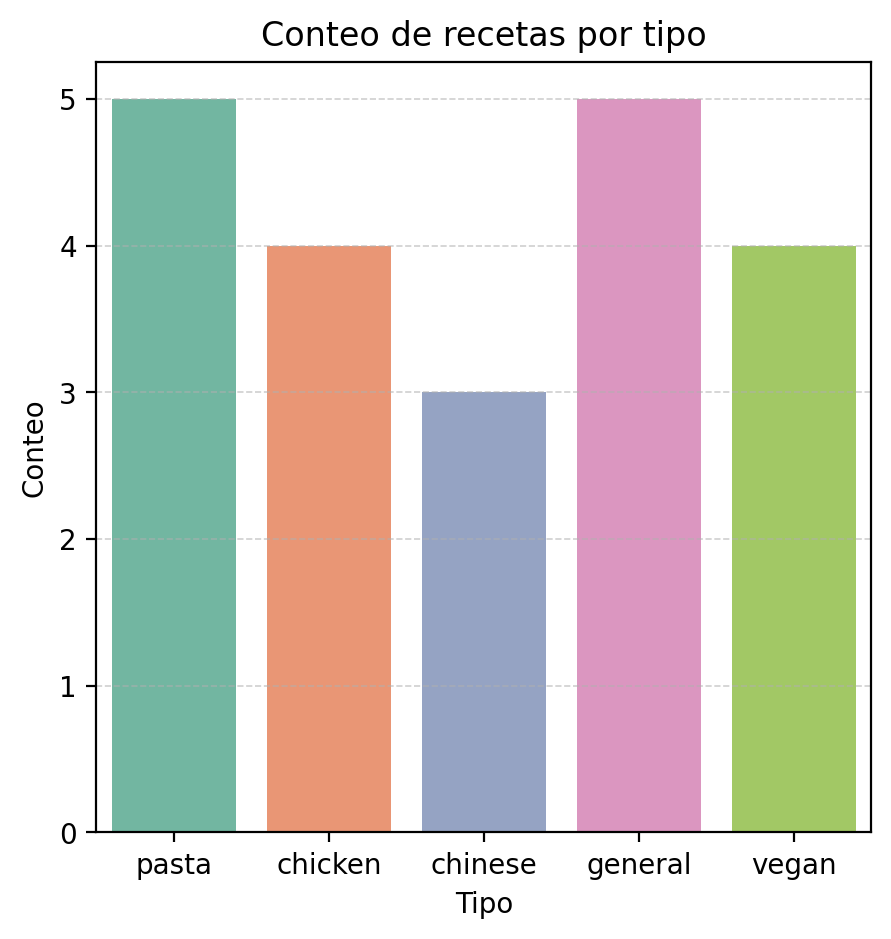

In [136]:
plt.figure(figsize=(5,5), dpi=200)
plt.title("Conteo de recetas por tipo")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.countplot(data=df_recetas, x="recipe_type_id", palette="Set2")
plt.xlabel("Tipo")
plt.ylabel("Conteo")
plt.show()

Esto nos permitirá evaluar la relevancia de ciertos resultados en los siguientes análisis.

El siguiente análisis que realizaremos será el de lo saludable que es una receta procedente de las redes según el tipo de receta. Esto nos permitirá ver las tendencias de salud por tipos de las recetas más virales.

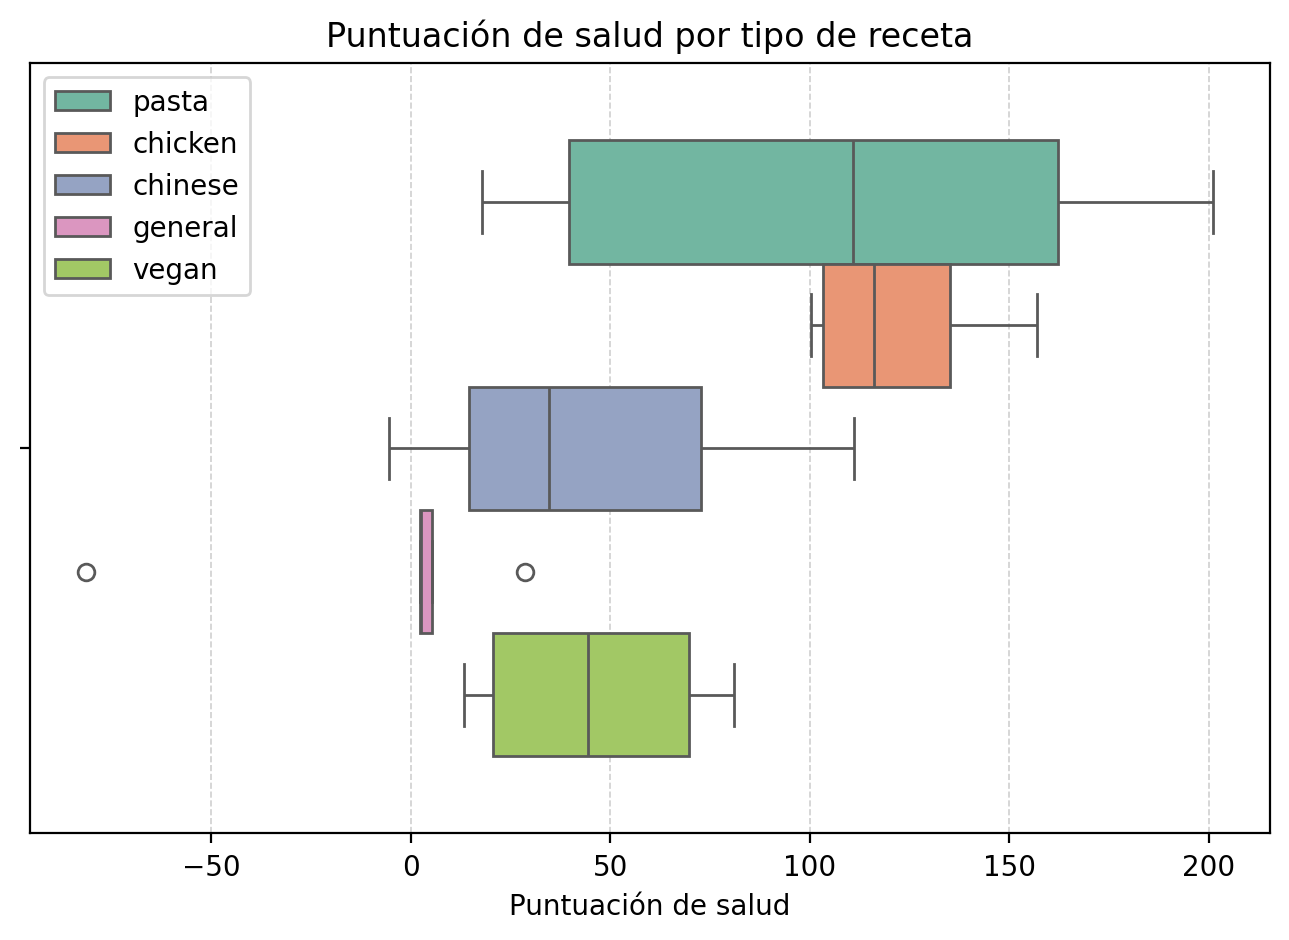

In [135]:
plt.figure(figsize=(8,5), dpi = 200)
plt.title("Puntuación de salud por tipo de receta")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.boxplot(df_recetas, x = "health_score", hue = "recipe_type_id", palette = 'Set2')
plt.legend()
plt.xlabel("Puntuación de salud")
plt.show()

Observamos que las recetas más consistentemente saludables son aquellas de pollo. Esto no quiere decir que las recetas más saludables sean las de este tipo, sino que son las que presentan menor dispersión en el espectro superior de la escala. Hay recetas de pasta más saludables que las de pollo, pero estas están muy dispersas. Las recetas generales son las únicas que presentan valores atípicos, lo cual tiene sentido al tratarse de recetas que pueden pertenecer a diversos grupos, haciendo que tengan características muy diversas.

También podemos analizar la puntuación de salud en cuanto a la viralidad de las recetas (número de visualizaciones):

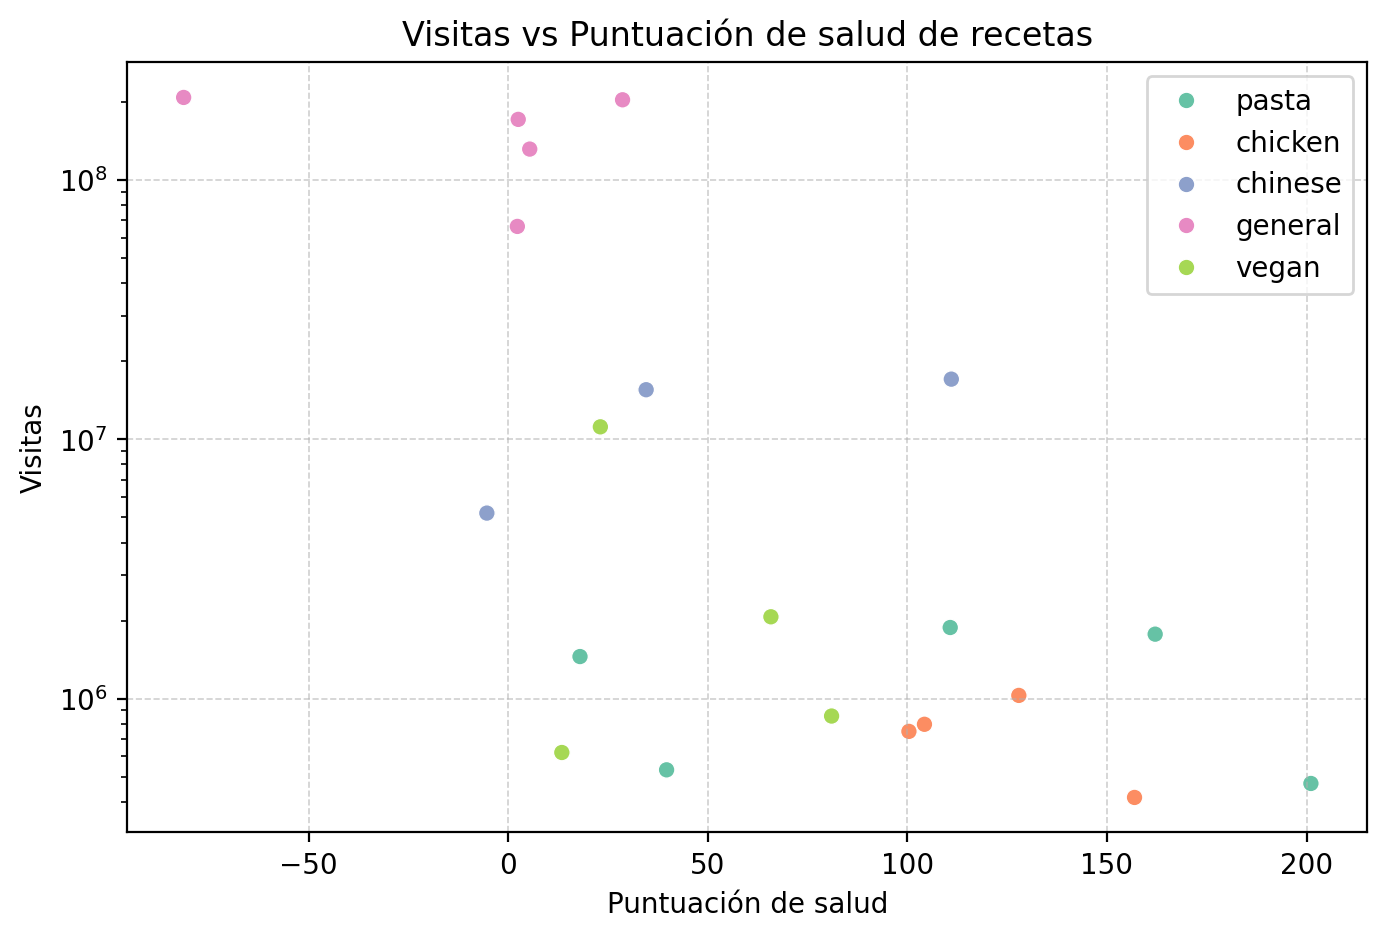

In [134]:
plt.figure(figsize = (8,5), dpi = 200)
plt.title("Visitas vs Puntuación de salud de recetas")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.scatterplot(data = df_recetas, x = "health_score", y = "views", hue = "recipe_type_id", palette="Set2")
plt.yscale('log')
plt.xlabel("Puntuación de salud")
plt.ylabel("Visitas")
plt.legend()
plt.show()

En escala logarítmica vemos una clara tendencia: las recetas menos saludables son las más vistas. Además, que la tendencia sea lineal en una escala logarítmica indica que es una tendencia exponencial negativa, es decir que las visitas decrecen exponencialmente cuanto más saludables son. Adicionalmente, las recetas con más visitas se concentran en las recetas resultantes de la búsqueda general, lo cual es consistente con el análisis anterior.

También podemos analizar las visitas según la fecha de publicación, para ver si hay fechas donde las recetas que se publican se hacen más virales:

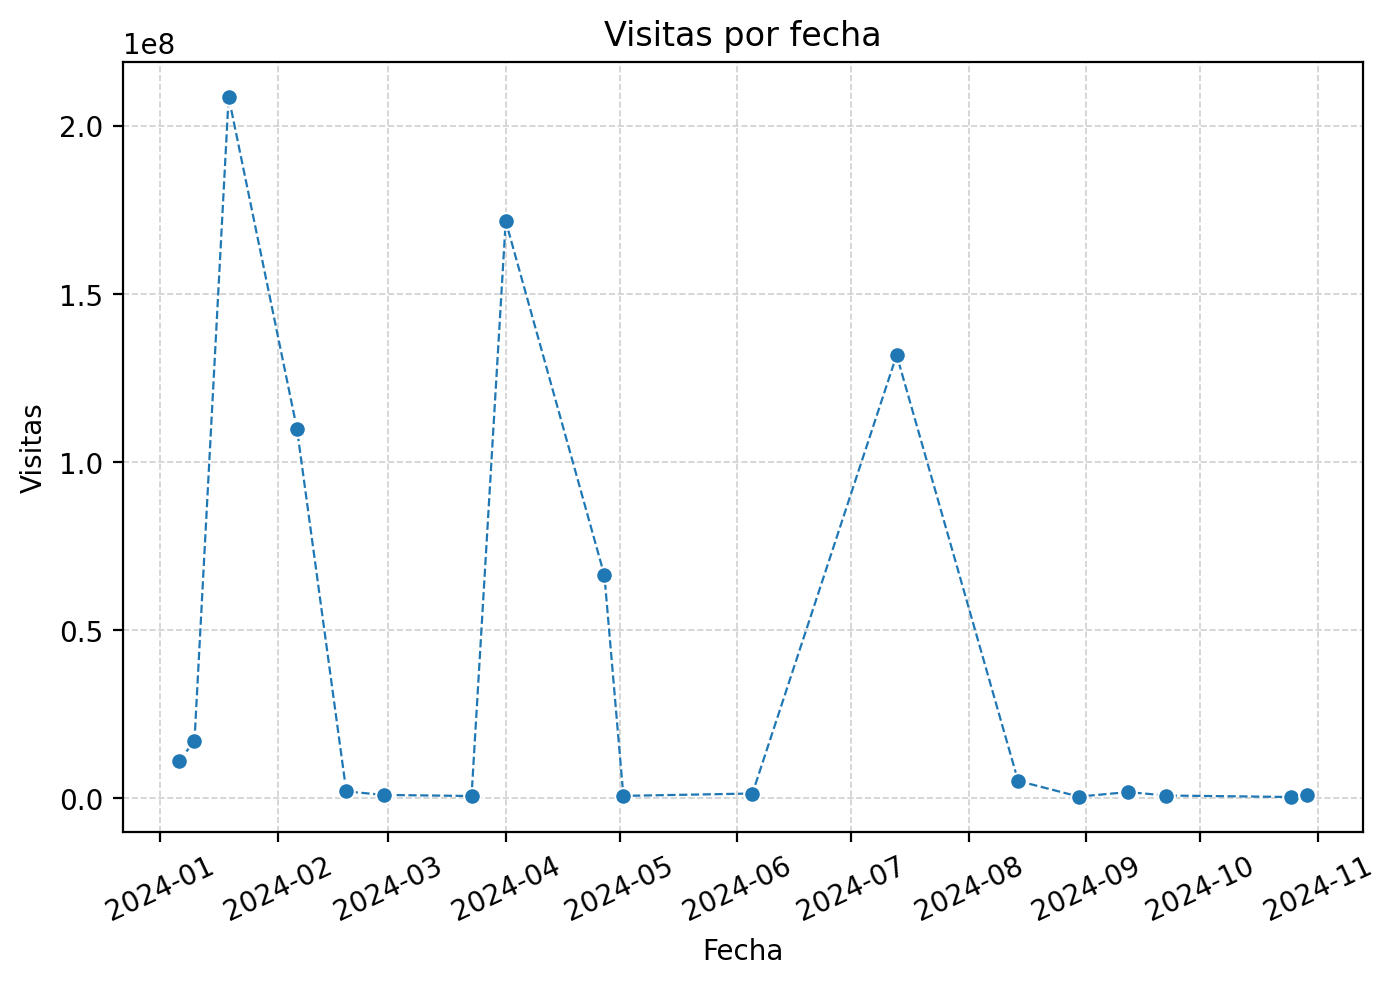

In [137]:
plt.figure(figsize = (8,5), dpi = 200)
plt.title("Visitas por fecha")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.lineplot(data = df_recetas, x = "date", y = "views", marker = "o", 
             err_style=None, ls = '--', lw = 0.8)
plt.xlabel("Fecha")
plt.ylabel("Visitas")
plt.xticks(rotation = 25)
plt.show()

A primera vista podríamos concluir que hay ciertas fechas donde se producen más visitas. Sin embargo esto no es así, ya que los picos pertenecen a las recetas generales que vimos previamente que tenían muchas más visitas que el resto. Podemos volver a realizar el análisis excluyendo estos valores:

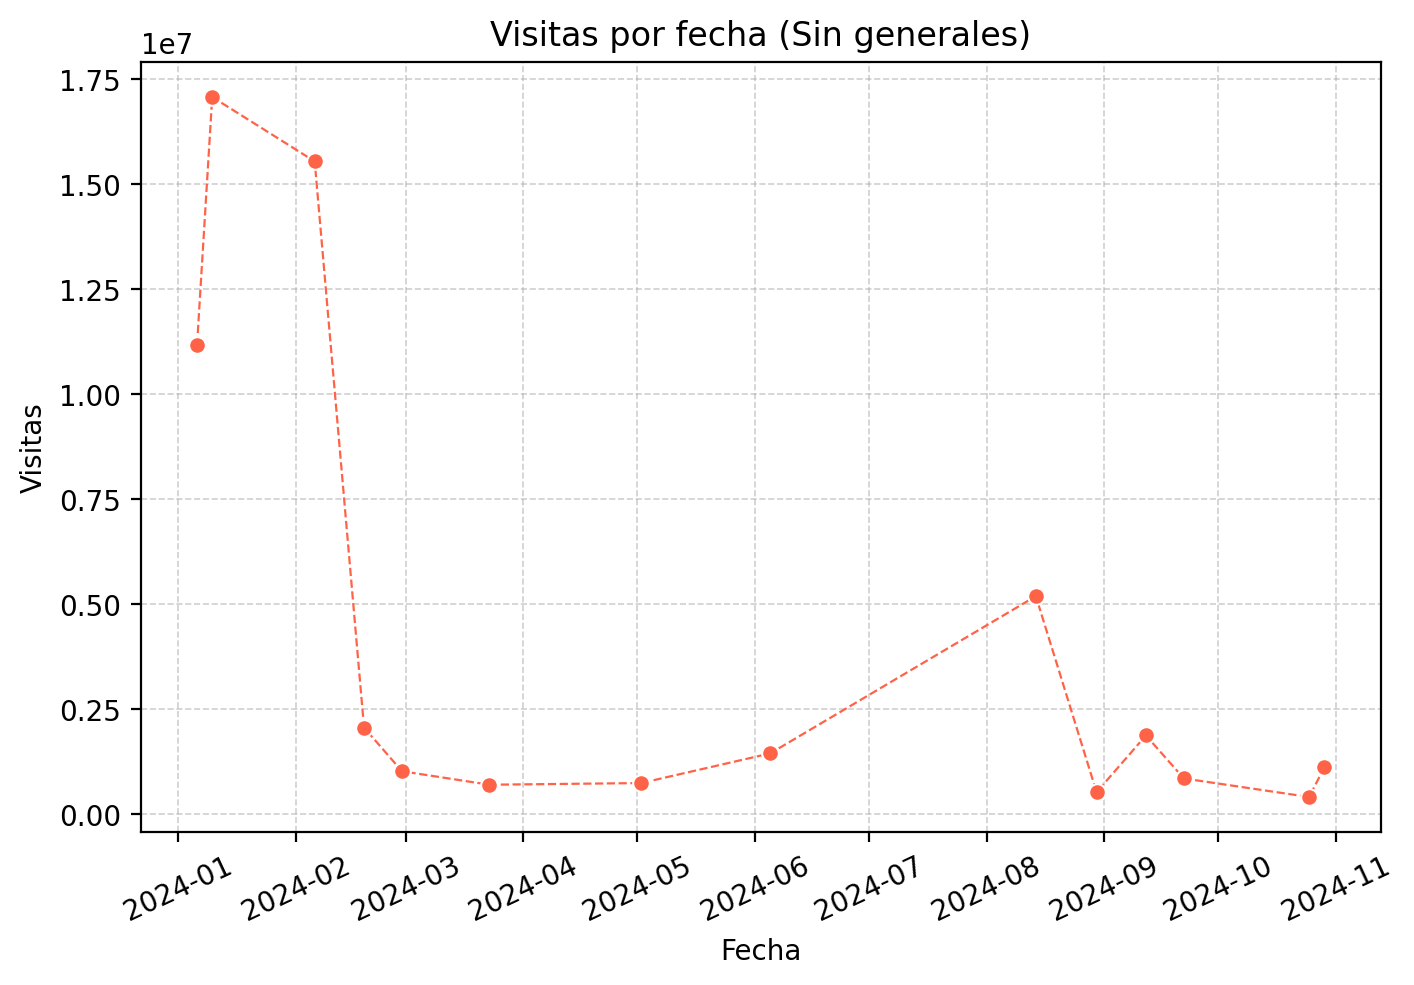

In [138]:
plt.figure(figsize = (8,5), dpi = 200)
plt.title("Visitas por fecha (Sin generales)")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.lineplot(data = df_recetas[df_recetas["recipe_type_id"] != "general"], 
             x = "date", y = "views", marker = "o", err_style=None, ls = '--', lw = 0.8, color = "tomato")
plt.xlabel("Fecha")
plt.ylabel("Visitas")
plt.xticks(rotation = 25)
plt.show()


Este gráfico podría representar mejor la métrica que intentamos averiguar. Vemos picos de visitas a principios de año, aunque esto es consistente con la lógica de las fechas: cuanto más antiguo, más tiempo para acumular visitas. Además nuestro conjunto de datos es bastante reducido, por lo que sería necesario ampliar la muestra para poder sacar alguna conclusión.

Ahora procedemos a ver los ingredientes más populares en las recetas.

In [104]:
conexion = establecer_conn('recetas', 'admin', 'postgres')
ingredientes_recetas = query_fetch(conexion, '''SELECT ir.ingredient_id, tr.type_name, r.title FROM ingredientes_receta ir 
                                            INNER JOIN recetas r ON r.recipe_id = ir.recipe_id
                                            INNER JOIN tipo_receta tr ON tr.recipe_type_id = r.recipe_type_id''')

In [62]:
conexion = establecer_conn('recetas', 'admin', 'postgres')
ingredientes = query_fetch(conexion, '''SELECT ingredient_id, ingredient_name FROM ingredientes''')

In [63]:
ing_mapper = {e[0] : e[1] for e in ingredientes} 

In [105]:
ing_rec_df = pd.DataFrame(ingredientes_recetas, columns = ["ingredient", "tipo", "nombre"])
ing_rec_df["ingredient"] = ing_rec_df["ingredient"].map(ing_mapper)

In [131]:
ing_counts = ing_rec_df["ingredient"].value_counts().head(7).reset_index()

In [132]:
ing_counts

,ingredient,count
0,garlic,11
1,salt,10
2,olive oil,8
3,water,7
4,Parmesan cheese,6
5,black pepper,5
6,white sugar,4


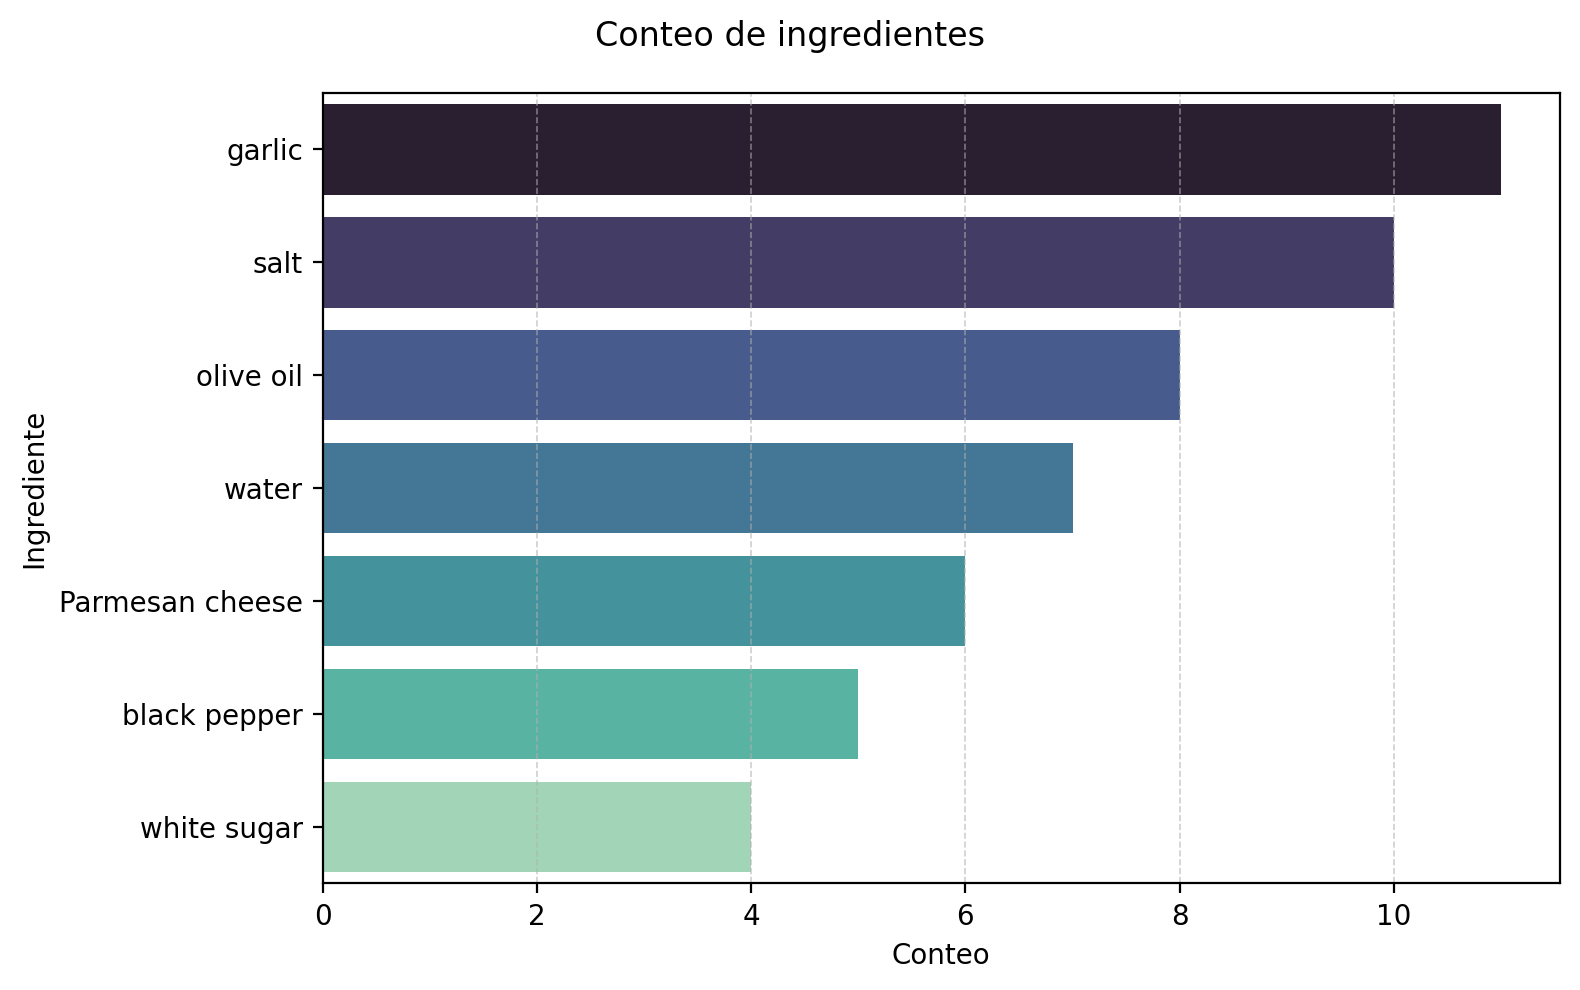

In [133]:
plt.figure(figsize=(8,5), dpi = 200)
plt.suptitle("Conteo de ingredientes")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
sns.barplot(data = ing_counts, x = 'count', y = "ingredient", palette = "mako")
plt.ylabel("Ingrediente")
plt.xlabel("Conteo")
plt.tight_layout()
plt.show()

Sabiendo que las recetas que más tenemos son las de pasta y generales, es normal que los ingredientes más comunes sean aquellos que se suelen relacionar a la gastronomía italiana y otros ingredientes genéricos, como la sal y la pimienta.